# Tutorial 10

Arcturus is one of the prominent stars in the Bootes constellation. An astronomer measures the intensity of Arcturus in the G and R filters of the SDSS system and obtains the values of intensity as shown in the cell below. Estimate the temperature of Arcturus to within +-50 K
. You may assume that Arcturus behaves like a perfect blackbody. The information provided below is sufficient for solving this question, and no additional information (such as radius of Arcturus) is required.

----------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from astropy.io import fits
from scipy.integrate import simpson

In [2]:
SDSS_filter = fits.open('filter_curves.fits')
SDSS_filter.info()

Filename: filter_curves.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   ()      
  1  U             1 BinTableHDU     20   47R x 5C   [E, E, E, E, E]   
  2  G             1 BinTableHDU     20   89R x 5C   [E, E, E, E, E]   
  3  R             1 BinTableHDU     20   75R x 5C   [E, E, E, E, E]   
  4  I             1 BinTableHDU     20   89R x 5C   [E, E, E, E, E]   
  5  Z             1 BinTableHDU     20   141R x 5C   [E, E, E, E, E]   


In [3]:
G = SDSS_filter[2].data
R = SDSS_filter[3].data

intensity_G = 1.3887e-09 * (u.W / u.m**2)
intensity_R = 2.5553e-09 * (u.W / u.m**2)

h = const.h
c = const.c
kB = const.k_B

$$
I_{\text{net}} = \frac{r^2}{d^2} \int_0^{\infty} B(\lambda, T) \, q(\lambda) \, d\lambda
$$

### Taking the ratio of the two intensities gives us a quantity that depends only on temperature.
### The idea is to estimate this ratio for a range of temperature values and then compare our ratio with the curve and find the corresponding temperature estimate.

In [4]:
def B(wl,T):
    exponential = 1/(np.exp(h*c/(wl*kB*T))-1)
    prefactor = 2*np.pi*h*c*c/wl**5
    return prefactor*exponential

In [5]:
ratio = intensity_G/intensity_R
print(ratio)

0.5434586936954565


In [6]:
wl_G = G['wavelength']*u.AA
wl_R = R['wavelength']*u.AA

qG = G['respt']
qR = R['respt']

In [7]:
def intensity_ratio(T):
    integral_G = 0*u.W/u.m**2
    integral_R = 0*u.W/u.m**2
    i = 1
    while i < len(wl_R):
        integral_R += B((wl_R[i-1]+wl_R[i])/2 , T)*(qR[i-1]+qR[i])/2*(wl_R[i]-wl_R[i-1])
        i = i + 1
    j = 1
    while j < len(wl_G):
        integral_G += B((wl_G[j-1]+wl_G[j])/2 , T)*(qG[j-1]+qG[j])/2*(wl_G[j]-wl_G[j-1])
        j = j + 1
    return (integral_G/integral_R)

In [8]:
T = np.arange(500, 10000, 100)*u.K

intensity_ratio_array = np.zeros(len(T))
for i, t in enumerate(T):
    intensity_ratio_array[i] = intensity_ratio(t)

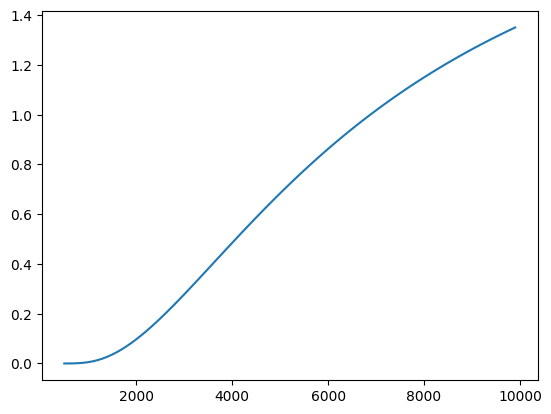

In [10]:
plt.plot(T, intensity_ratio_array)
plt.show()

In [11]:
difference_ratio = np.abs(intensity_ratio_array - ratio)
difference_ratio = difference_ratio[~np.isnan(difference_ratio)]

Temp = T[np.where(difference_ratio == np.amin(difference_ratio))][0]
print(Temp)

4300.0 K


The choice of **midpoint-B $\times$ average-q per bin (Method 1)** instead of directly applying **Simpson’s rule** to the product $B(\lambda)q(\lambda)$ **(Method 2)** is informed by the wavelength sampling, which is relatively coarse (\~25 Å steps) while the blackbody spectrum $B_\lambda(\lambda,T)$ is very smooth across each bin. The main variation inside a bin comes from the tabulated quantum efficiency curve $q(\lambda)$, which is well approximated by a linear average. By evaluating $B$ at the bin midpoint and pairing it with the averaged $q$, Method 1 preserves the smooth blackbody shape without being distorted by endpoint-only sampling of the product. This makes it more robust on coarse grids, while Method 2 is only more accurate if the integrand $Bq$ is finely sampled.